# Data Processing

In [ ]:
# Core libraries
import os
import glob
import time
import random
import shutil

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, SubsetRandomSampler
import torchvision
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Saving models
import joblib  # for saving the best SVM model

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:

base_path = '/content/gdrive/MyDrive/APS360_SkinCancer_Dataset'
training_path = os.path.join(base_path, 'ISIC_2019_Training_Input')


In [ ]:
# Image size for EfficientNetB2
IMAGE_SIZE = (260, 260)

# Image preprocessing function
def preprocess_image(image_path, image_size=IMAGE_SIZE):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(image_size)
    image_array = np.array(image) / 255.0
    return image_array

# Step 1: Get all image paths
all_image_paths = glob.glob(os.path.join(training_path, '*.jpg'))

print(f"Total images found: {len(all_image_paths)}")

Total images found: 21237


In [ ]:

# Path to metadata CSV (update if needed)
metadata_path = "/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/ISIC_2019_Training_GroundTruth.csv"

#Load GroundTruth and convert to single label
df = pd.read_csv(metadata_path)

# Columns in ISIC 2019 GT
classes = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']

# Make filename column
df['filename'] = df['image'].astype(str) + '.jpg'

# Ensures each row has atleast one positive
df['label_str'] = df[classes].idxmax(axis=1)

# Create encoders
label_mapping = {c: i for i, c in enumerate(classes)}
index_to_label = {i: c for c, i in label_mapping.items()}
df['label'] = df['label_str'].map(label_mapping)

# Keep files that are only present in image folder
all_image_paths = glob.glob(os.path.join(training_path, '*.jpg'))
name_to_path = {os.path.basename(p): p for p in all_image_paths}
df = df[df['filename'].isin(name_to_path.keys())].reset_index(drop=True)



In [ ]:
# Split training, validation and testing in ratio 70:15:15
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df, test_size=0.30, random_state=36, stratify=df['label']
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=36, stratify=temp_df['label']
)

print("Split sizes:", len(train_df), len(val_df), len(test_df))


Split sizes: 14584 3125 3126


Train class counts BEFORE augmentation:
 label_str
MEL     2573
NV      7534
BCC     1839
AK       484
BKL     1522
DF       135
VASC     140
SCC      357
UNK        0
Name: count, dtype: int64


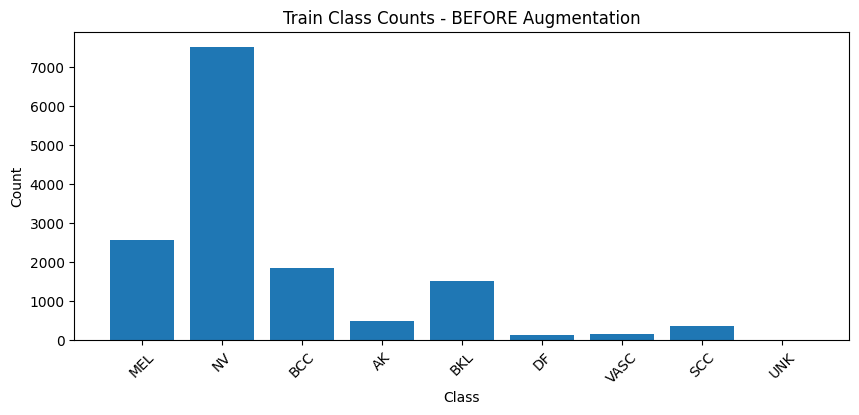

In [ ]:
# Checks the imbalance if classes before applying augmentation
classes = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']
before_counts = train_df['label_str'].value_counts().reindex(classes, fill_value=0)
print("Train class counts BEFORE augmentation:\n", before_counts)

# Plots the imbalance
plt.figure(figsize=(10,4))
plt.bar(before_counts.index, before_counts.values)
plt.title("Train Class Counts - BEFORE Augmentation")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:

from torchvision import transforms

# Transformation without augmentation to be applied on validation and testing
eval_tfms = transforms.Compose([
    transforms.Resize((224, 224)),        # Resize to ResNet size
    transforms.ToTensor(),                 # Convert to tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],       # ImageNet mean
        std=[0.229, 0.224, 0.225]         # ImageNet std
    )
])

# Transformation with randomn augmentation to be applied on training
transform_train_aug = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=180),
    transforms.ColorJitter(brightness=0.08, contrast=0.08, saturation=0.04, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.01, 0.04), ratio=(0.3, 3.0)),
])


# Class for making Datasets
class ImagePathDataset(Dataset):

    def __init__(self, df_split, name_to_path, transform=None):

        self.transform = transform
        self.items = []
        for _, row in df_split.iterrows():
            fn = row['filename']
            if fn in name_to_path:
                self.items.append((name_to_path[fn], int(row['label'])))

    #Called by DataLoader function
    def __len__(self):
        return len(self.items)


    #Called by DataLoader function
    def __getitem__(self, idx):
        path, label = self.items[idx]
        try:
            img = Image.open(path).convert('RGB')
        except Exception:
            # Replace with black image if the image is corrupted
            img = Image.new('RGB', (224, 224), (0, 0, 0))
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)




In [ ]:

# Oversample minority classes to match majority count
import numpy as np

# Count by class name in a dictionary
counts_by_class = train_df['label_str'].value_counts().to_dict()
majority_count = max(counts_by_class.values())
target = int(0.8 * majority_count)   # PPROXIMtely balance the classees

balanced_parts = [] #Holds balanced data for each class

rng = np.random.default_rng(36)

for cls in classes:
    cls_df = train_df[train_df['label_str'] == cls]
    n = len(cls_df) #Count number of samples for each class
    if n == 0:
        continue
    if n < target:
        # if class has less samples than oversample by duplicating
        idx = rng.choice(cls_df.index.values, size=target, replace=True)
        balanced_parts.append(cls_df.loc[idx])
    else:
        balanced_parts.append(cls_df)

balanced_train_df = pd.concat(balanced_parts, axis=0).sample(frac=1.0, random_state=36).reset_index(drop=True)




Train class counts AFTER augmentation-oversampling (by file copies):
 label_str
MEL     6027
NV      7534
BCC     6027
AK      6027
BKL     6027
DF      6027
VASC    6027
SCC     6027
UNK        0
Name: count, dtype: int64


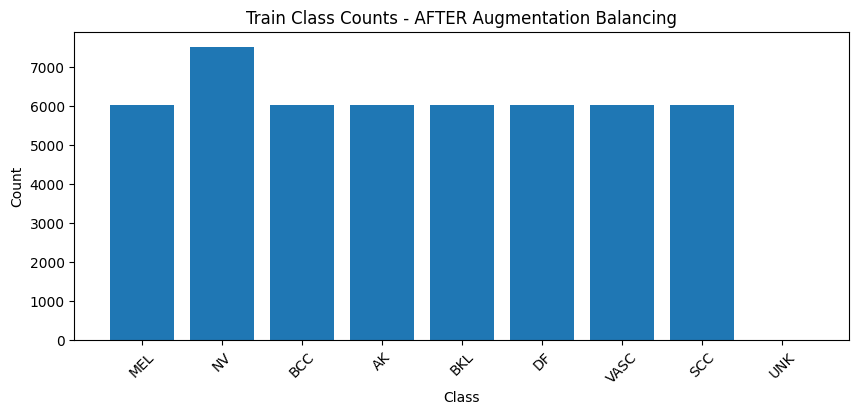

In [ ]:

# Check the number of samples in each class after oversmapling to check if they are balanced
after_counts = balanced_train_df['label_str'].value_counts().reindex(classes, fill_value=0)
print("\nTrain class counts AFTER augmentation-oversampling (by file copies):\n", after_counts)

# Quick bar plot
plt.figure(figsize=(10,4))
plt.bar(after_counts.index, after_counts.values)
plt.title("Train Class Counts - AFTER Augmentation Balancing")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Information for making Data Loaders
BATCH_SIZE   = 32
NUM_WORKERS  = 4
PIN_MEMORY   = True


# Rebuild Datasets and then Dataloaders. Use augmented transforms for training only
train_ds_bal = ImagePathDataset(balanced_train_df, name_to_path, transform=transform_train_aug)
val_ds       = ImagePathDataset(val_df,       name_to_path, transform=eval_tfms)
test_ds      = ImagePathDataset(test_df,      name_to_path, transform=eval_tfms)

train_loader = DataLoader(train_ds_bal, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds,     batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_ds,    batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print("\nBatches after balancing (train/val/test):", len(train_loader), len(val_loader), len(test_loader))



Batches after balancing (train/val/test): 1554 98 98


# Model Processing

In [ ]:
resnet = torchvision.models.resnet18(pretrained=True)

resnet.eval()

# Remove the last fully connected layer
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
feature_extractor = feature_extractor.to(device)


#This function is for extracting the features from the data given
def save_features(dataloader):
  all_features = []  # store feature tensors
  all_labels = []    # store labels
  n =0

  with torch.no_grad():
      for images, labels in dataloader:
          # Move them to either cpu or cuda depending on the runtime type
          images = images.to(device)
          labels = labels.to(device)

          # Extract features
          feats = feature_extractor(images)
          feats = feats.view(feats.size(0), -1)

          all_features.append(feats.cpu())
          all_labels.append(labels.cpu())

          #Keep track of the excution
          n=n+1
          print("Done ", n)

  #concatenates multiple tensors
  return torch.cat(all_features), torch.cat(all_labels)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(device) #check the device being used

cuda


In [ ]:

#Extract features
features_train, labels_train = save_features(train_loader)

In [ ]:
#Save extracted features to a file
torch.save({
    'features': features_train,
    'labels': labels_train
}, '/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/Processed_Final_BaseLine_Data/train_features.pt')

print("Saved train features to Google Drive!")

In [ ]:

#Extract features
features_val, labels_val = save_features(val_loader)

#Save extracted features to a file
torch.save({
    'features': features_val,
    'labels': labels_val
}, '/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/Processed_Final_BaseLine_Data/val_features.pt')

print("Saved validation features to Google Drive!")


In [ ]:

#Extract features
features_test, labels_test = save_features(test_loader)

#Save extracted features to a file
torch.save({
    'features': features_test,
    'labels': labels_test
}, '/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/Processed_Final_BaseLine_Data/test_features.pt')

print("Saved testing features to Google Drive!")


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
import joblib

def train_svm_linear(features_train, labels_train, features_val, labels_val, features_test, labels_test,
                     C_values=(0.01, 0.1, 1, 10, 100), max_iter=20000):

    # Convert PyTorch tensors to NumPy arrays (ensure CPU)
    X_train = features_train.cpu().numpy()
    y_train = labels_train.cpu().numpy()
    X_val   = features_val.cpu().numpy()
    y_val   = labels_val.cpu().numpy()
    X_test  = features_test.cpu().numpy()
    y_test  = labels_test.cpu().numpy()

    # Merge training and validation sets for final better retraining
    X_train_full = np.concatenate([X_train, X_val], axis=0)
    y_train_full = np.concatenate([y_train, y_val], axis=0)

    print(f"Train size: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

    # Hyperparameter search over C values using validation accuracy
    best_acc, best_C = -1.0, None
    for C in C_values:
        clf = make_pipeline(
            StandardScaler(with_mean=True, with_std=True),          # Normalize features
            LinearSVC(C=C, class_weight='balanced', max_iter=max_iter)  # Balanced class weights
        )
        clf.fit(X_train, y_train)                                   # Train on training set
        acc = clf.score(X_val, y_val)                               # Evaluate on validation set
        print(f"C={C} | Val Acc={acc:.4f}")
        if acc > best_acc:                                          # Track best C
            best_acc, best_C = acc, C

    print(f"[LinearSVC] Best C={best_C} (Val Acc={best_acc:.4f})")

    # Retrain on combined training and validation data with best C
    svm_model_final = make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        LinearSVC(C=best_C, class_weight='balanced', max_iter=max_iter)
    )
    svm_model_final.fit(X_train_full, y_train_full)

    # Final evaluation on the test set
    test_acc = svm_model_final.score(X_test, y_test)
    print(f"[LinearSVC] Final Test Accuracy: {test_acc:.4f}")

    # Save model to disk for reuse
    joblib.dump(svm_model_final, 'best_linear_svm.pkl')

    return svm_model_final, test_acc


In [ ]:
# Linear
linear_model, linear_test_acc = train_svm_linear(
    train_features, train_labels, val_features, val_labels, test_features, test_labels
)

Train size: 49723 | Val: 3125 | Test: 3126
C=0.01 | Val Acc=0.4922
C=0.1 | Val Acc=0.4928
C=1 | Val Acc=0.4925
C=10 | Val Acc=0.4925
C=100 | Val Acc=0.4925
[LinearSVC] Best C=0.1 (Val Acc=0.4928)
[LinearSVC] Final Test Accuracy: 0.6056


Save the model to Drive to be reused later

In [ ]:
!mkdir -p '/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/Processed_Final_BaseLine_Data/Baseline_Model_2'


In [ ]:
!cp /content/best_linear_svm.pkl '/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/Processed_Final_BaseLine_Data/Baseline_Model'

### Reloads the final svm model that was saved in the drive



In [ ]:
model_path = '/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/Processed_Final_BaseLine_Data/Baseline_Model/best_linear_svm.pkl'

final_svm = joblib.load(model_path)


### Reloads the features extracted from RESNET-18 and were saved in the drive

In [ ]:

# For training set features extracted from ResNet
train_data = torch.load('/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/Processed_Final_BaseLine_Data/train_features.pt')

# Get the tensors
train_features = train_data['features']
train_labels = train_data['labels']

# For validation set features extracted from ResNet
val_data = torch.load('/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/Processed_Final_BaseLine_Data/val_features.pt')

# Get the tensors
val_features = val_data['features']
val_labels = val_data['labels']

# For testing set features extracted from ResNet
test_data = torch.load('/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/Processed_Final_BaseLine_Data/test_features.pt')

# Get the tensors
test_features = test_data['features']
test_labels = test_data['labels']

In [ ]:
# Combine features for better training of the final model
train_full_features = np.concatenate([train_features, val_features], axis=0)

# Combine labels for better training of the final model
train_full_labels = np.concatenate([train_labels, val_labels], axis=0)


# Evaluates the Final SVM Model

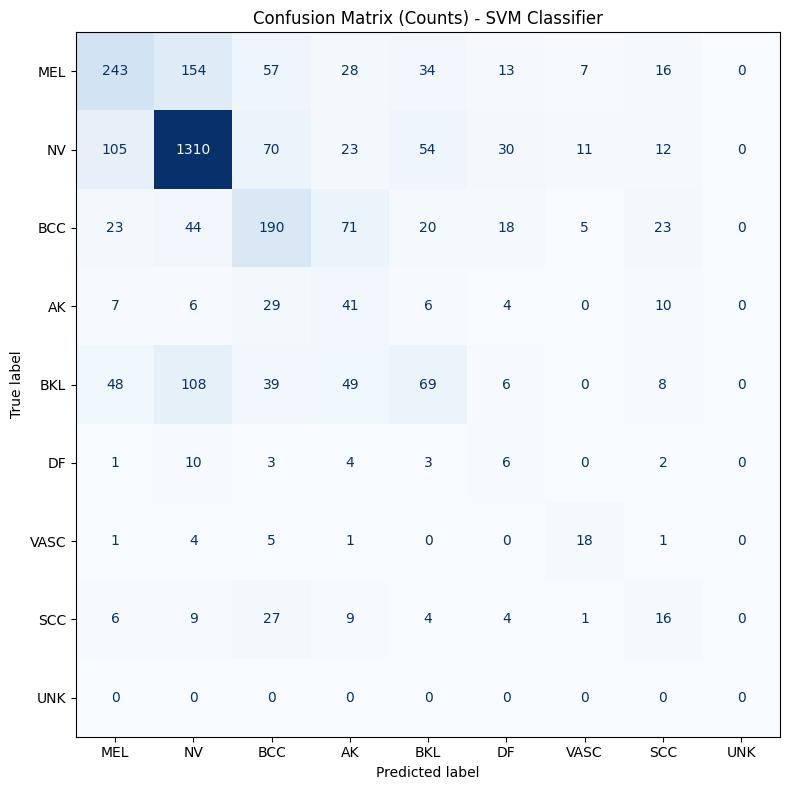

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ordered_labels = list(range(9))  # ensures a 9x9 matrix in order
class_names = [index_to_label[i] for i in ordered_labels]

# Predict on test set
test_pred = final_svm.predict(test_features)

# Compute confusion matrix with fixed label size
cm = confusion_matrix(test_labels, test_pred, labels=ordered_labels)

# Plots the matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False)
ax.set_title('Confusion Matrix (Counts) - SVM Classifier')
plt.tight_layout()
plt.show()



In [ ]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import numpy as np

def eval_linear_svc(clf, X_test, y_test, label_names=None):

    X_test = X_test.cpu().numpy()
    y_test = y_test.cpu().numpy()

    y_pred = clf.predict(X_test)

    # Weighted F1
    f1_w = f1_score(y_test, y_pred, average='weighted')
    print(f"Weighted Average F1 Score: {f1_w:.4f}\n")

    # Classification report
    if label_names is not None:
        # Ensure labels are in the right order
        labels = list(range(len(label_names)))
        print("Full Classification Report:")
        print(classification_report(
            y_test, y_pred,
            labels=labels,
            target_names=label_names,
            digits=4,
            zero_division=0
        ))
    else:
        print("Full Classification Report:")
        print(classification_report(y_test, y_pred, digits=4, zero_division=0))


eval_linear_svc(final_svm, test_features, test_labels, classes)


Weighted Average F1 Score: 0.6078

Full Classification Report:
              precision    recall  f1-score   support

         MEL     0.5599    0.4402    0.4929       552
          NV     0.7964    0.8111    0.8037      1615
         BCC     0.4524    0.4822    0.4668       394
          AK     0.1814    0.3981    0.2492       103
         BKL     0.3632    0.2110    0.2669       327
          DF     0.0741    0.2069    0.1091        29
        VASC     0.4286    0.6000    0.5000        30
         SCC     0.1818    0.2105    0.1951        76
         UNK     0.0000    0.0000    0.0000         0

    accuracy                         0.6056      3126
   macro avg     0.3375    0.3733    0.3426      3126
weighted avg     0.6205    0.6056    0.6078      3126



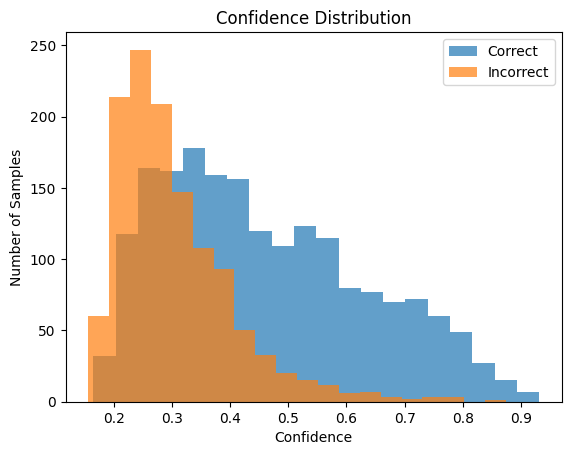

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def confidence_distribution(clf, X_test, y_test):

    X_test = X_test.cpu().numpy();
    y_test = y_test.cpu().numpy()

    # Predictions
    y_pred = clf.predict(X_test)


    # Decision scores
    scores = clf.decision_function(X_test)

    # Take the score for the predicted class and normalize with softmax
    from scipy.special import softmax
    probs_like = softmax(scores, axis=1)
    confidences = np.max(probs_like, axis=1)  # Highest class score per sample

    # Split correct vs incorrect
    correct_conf = confidences[y_pred == y_test]
    incorrect_conf = confidences[y_pred != y_test]

    # Plot the graph
    plt.hist(correct_conf, bins=20, alpha=0.7, label='Correct')
    plt.hist(incorrect_conf, bins=20, alpha=0.7, label='Incorrect')
    plt.xlabel('Confidence')
    plt.ylabel('Number of Samples')
    plt.title('Confidence Distribution')
    plt.legend()
    plt.show()

    return correct_conf, incorrect_conf

correct_conf, incorrect_conf = confidence_distribution(final_svm, test_features, test_labels)
